Welcome! In this notebook we'll walk through a simple example of how to create a normalizing flow in JAX using `jax-flows`!

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
import matplotlib.pyplot as plt
#from sklearn import datasets, preprocessing
from IPython.display import clear_output
import jax.numpy as np
import numpy
from jax import random
from bslibs.plot.qqplot import qqplot
from tensorflow_probability.substrates import jax as tfp
import optax

tfd = tfp.distributions

%matplotlib inline

First, we'll load a dataset of 10,000 2-dimensional points into a matrix $X \in \mathbb{R}^{10000 \times 2}$.

n_samples = 10000
plot_range = [(-2, 2), (-2, 2)]
n_bins = 100

scaler = preprocessing.StandardScaler()
X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
X = scaler.fit_transform(X)
plt.hist2d(X[:, 0], X[:, 1], bins=n_bins, range=plot_range)[-1]

In [22]:
from spg import data_utils
data = data_utils.load_data()
data = data.values

data = data + random.uniform(random.PRNGKey(1), data.shape)*0.1
rain_day = np.ones_like(data)
rain_day = rain_day.at[data <= 0.1].set(0.0)
#data = np.log(data)

scale = data.std()
data = data / scale

X = np.stack([data, rain_day], axis=1)

n_samples = X.shape[0]

In [14]:
import sys
sys.path.append('..')

import flows

from jax import grad, jit, random, value_and_grad
from jax.experimental import stax, optimizers

/home/leroy/mambaforge/envs/bs310/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '
/home/leroy/mambaforge/envs/bs310/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


Next, we'll define some training parameters.

In [15]:
rng, flow_rng = random.split(random.PRNGKey(0))
input_dim = X.shape[1]
num_epochs, batch_size = 200, 512

Now it's time to construct the normalizing flow model. We'll opt for `MAF` composed of a sequence of 5 blocks.

The core of this library is the concept of a _bijection_. A bijection is characterized by a triplet $(\theta, f_\theta, f^{-1}_\theta)$, where $\theta$ is a parameter vector, and for all $x \in \mathbb{R}^N$, it's the case that $x = f^{-1}_\theta(f_\theta(x))$. Given this characterization, bijections naturally follow a common interface, as described next. 

When you create a bijection, it returns an initialization function `init_fun` which, given a source of randomness `rng` and an `input_dim` tuple returns the aforementioned triplet `(params, direct_fun, inverse_fun)`.

`params` is consistent with the rest of JAX, and is just a tree of numpy matrices containing all of the trainable parameters of the bijection. More importantly, the `direct_fun` and `inverse_fun` are the functions which perform direct and inverse bijections according to params. That is, given `params` and `inputs`, each will return `(outputs, log_det_jacobian)`.

It's worth noting that the composition of several bijections, retrievable by a call to `serial`, is simply a larger, meta-bijection. That is, it adheres to the exact same bijection interface described previously and is indistinguishable from any other bijection.

A _flow_ is such a bijection paired with a prior distribution. A prior distribution should allow one to query the density of a point and sample new points, i.e. it should return `log_pdf` and `sample` functions. Typically a normal distribution is used as the prior, and is used as the implicit default parameter when constructing a flow.

In [29]:

def Gamma():
    """
    Returns:
        A function mapping ``(rng, input_dim)`` to a ``(params, log_pdf, sample)`` triplet.
    """

    def init_fun(rng, input_dim):

        params = np.zeros(2) + 0.5

        def log_pdf(params, inputs):
            id_print(params)
            return tfd.Gamma(*params).log_prob(inputs, 1.0).sum(1)

        def sample(rng, params, num_samples=1):
            return tfd.Gamma(*params).sample((num_samples, input_dim), seed=rng)

        return params, log_pdf, sample

    return init_fun


def LogNormal():
    """
    Returns:
        A function mapping ``(rng, input_dim)`` to a ``(params, log_pdf, sample)`` triplet.
    """

    def init_fun(rng, input_dim):
        def log_pdf(params, inputs):
            return tfd.LogNormal(0.0, 1.0).log_prob(inputs, 1.0).sum(1)

        def sample(rng, params, num_samples=1):
            return tfd.LogNormal(0.0, 1.0).sample((num_samples, input_dim), seed=rng)

        return (), log_pdf, sample

    return init_fun


In [17]:
def get_masks(input_dim, hidden_dim=64, num_hidden=1):
    masks = []
    input_degrees = np.arange(input_dim)
    degrees = [input_degrees]

    for n_h in range(num_hidden + 1):
        degrees += [np.arange(hidden_dim) % (input_dim - 1)]
    degrees += [input_degrees % input_dim - 1]

    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [np.transpose(np.expand_dims(d1, -1) >= np.expand_dims(d0, 0)).astype(np.float32)]
    return masks

def maskedDenseCond(mask):
    return np.concatenate()

def masked_transform(rng, input_dim):
    masks = get_masks(input_dim, hidden_dim=64, num_hidden=1)
    act = stax.gelu
    init_fun, apply_fun = stax.serial(
        flows.MaskedDense(masks[0]),
        act,
        flows.MaskedDense(masks[1]),
        act,
        flows.MaskedDense(masks[2].tile(2)),
    )
    _, params = init_fun(rng, (input_dim,))
    return params, apply_fun


Now, given the model, we can start to optimize it. We can do this by creating a regular JAX Adam optimizer, supplying it the model parameters.

In [18]:
from tqdm.notebook import trange
import itertools
import numpy.random as npr

from jax.experimental.host_callback import id_print
from jax import lax


Now we'll define the loss we'd like to minimize, as well as the step function which will update our parameters given a batch and compile it.

In [19]:

def l1(params, inputs):
    l = -log_pdf(params, inputs)
    return l.mean()

def loss(params, inputs):
    l = -log_pdf(params, inputs)#*((inputs[:, 0]+2.23)**2 + 1)*fac
    return l.mean()

def opt_update(opt, grads, opt_state, params):
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

    # return lax.cond(np.isfinite(val).all(), 
    #         lambda args : opt_update(*args), 
    #         lambda args : (args[-1], args[-2]),
    #         (opt, gradients, opt_state, params))

And now we train!

In [20]:
import warnings
warnings.filterwarnings("ignore")


In [32]:
init_fun = flows.Flow(
    flows.Serial(*(flows.MADE(masked_transform), flows.Reverse())* 20),
    flows.Normal(),
)

params, log_pdf, sample = init_fun(flow_rng, input_dim)

TypeError: 'function' object is not iterable

In [57]:
opt = optax.radam(1e-5)
opt_state = opt.init(params)

In [58]:
@jit
def step(inputs, opt_state, params):
    val, gradients = value_and_grad(loss)(params, inputs)
    updates, opt_state = opt.update(gradients, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state
    

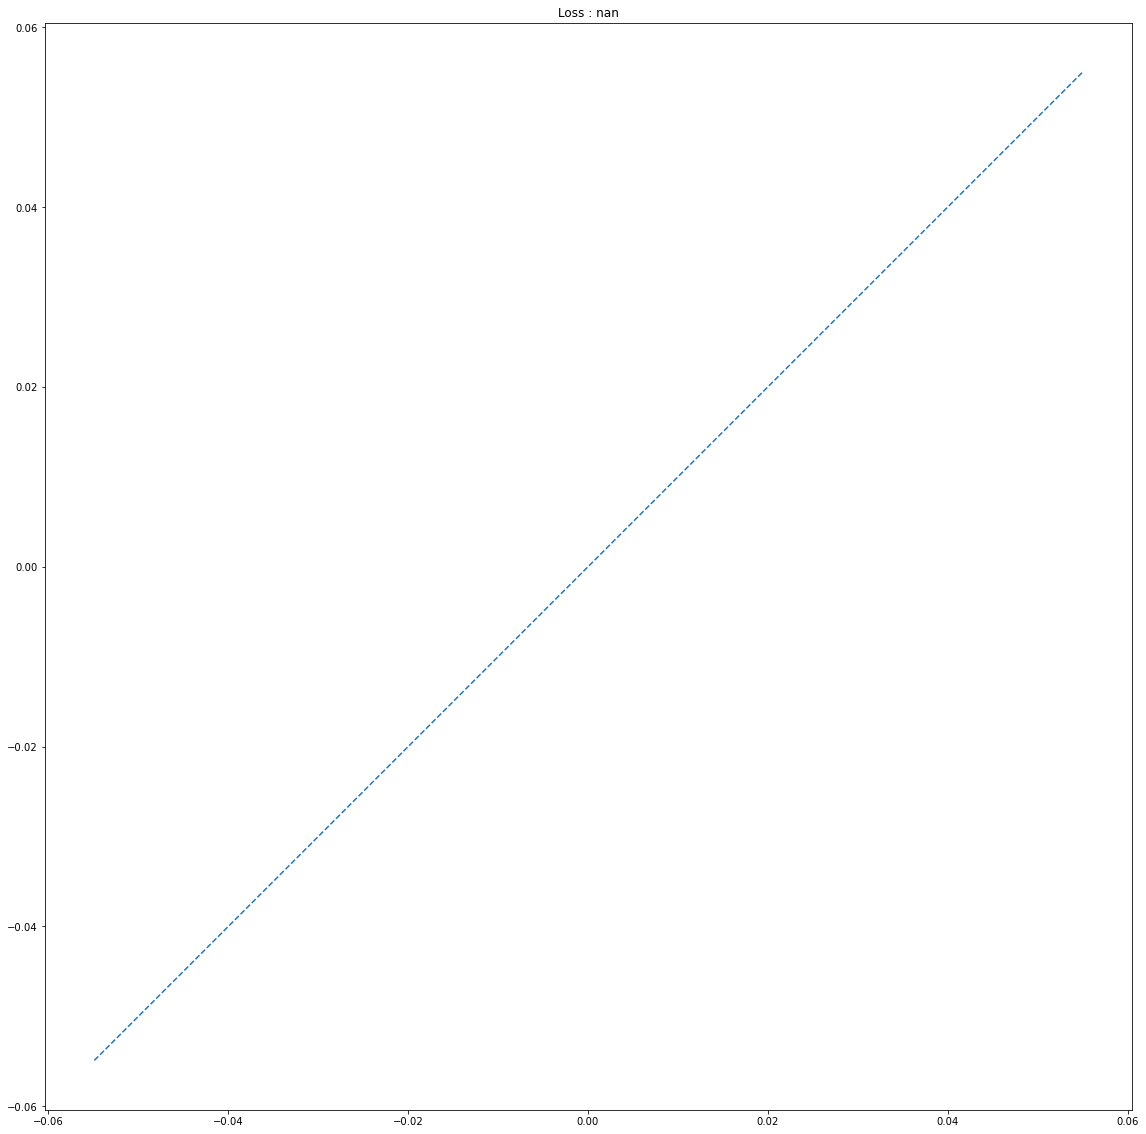

62


KeyboardInterrupt: 

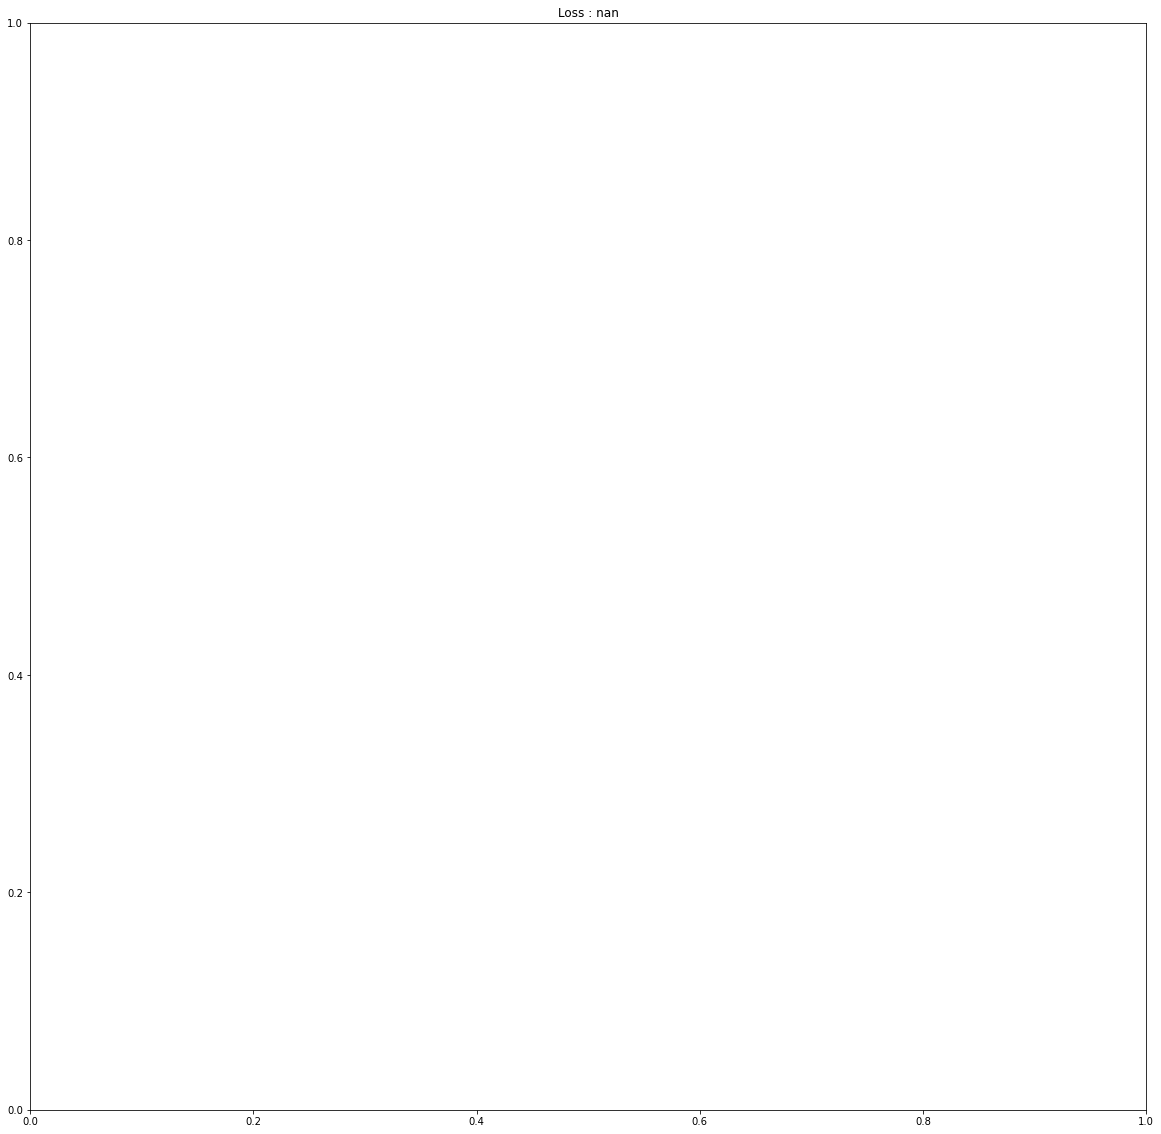

In [59]:
itercount = itertools.count()

rng_or = rng
for epoch in range(num_epochs):
    permute_rng, rng = random.split(rng)
    X = random.permutation(permute_rng, X)
    for batch_index in range(0, len(X), batch_size):
        
        params, opt_state = step(X[batch_index:batch_index+batch_size], opt_state, params)
    
    print(epoch)
        #print(params)
    #next(itercount)

    X_syn = sample(rng_or, params, X.shape[0])
    l = l1(params, X_syn)

    X_syn = numpy.asarray(X_syn*scale)


    plt.figure(figsize=(20,20))
    plt.title(f'Loss : {l}')
    #qqplot((X[:, 0]*scale), X_syn[:, 0])
    qqplot((np.exp(X[:, 0]*scale)), np.exp(X_syn[:, 0]))

    #plt.ylim(0, 25)
    
    #plt.hist(numpy.asarray(X_syn[:, 0]))#, X_syn[:, 1], bins=n_bins, range=plot_range)
    clear_output(wait=True) # Clear plotting
    plt.show()

In [22]:
plt.scatter(X_syn[:, 0], X_syn[:, 1])

5.9770985

In [24]:
X_syn[:,  0].max()

5.853661

In [29]:
sample_rng, rng = random.split(rng)
X_syn = sample(rng, params, X.shape[0])

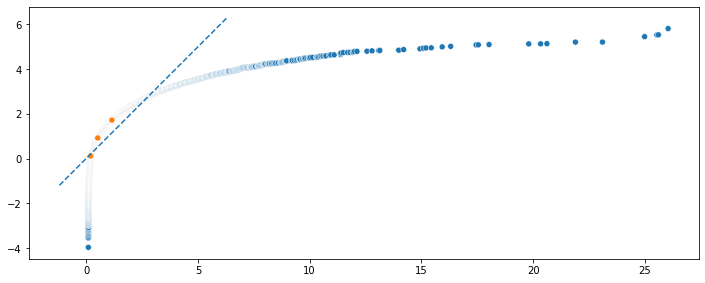

In [31]:
plt.figure(figsize=(12, 8))
qqplot(X[:, 0]*scale, X_syn[:, 0]*scale)
#plt.ylim(0, 25)
plt.savefig('image.png')

_Magic._